# SVM算法

主要是SMO(序列最小化优化算法)的实现

In [1]:
%matplotlib inline

import numpy as np
import random
import math
from matplotlib import pyplot as plt

In [2]:
'''
load dataset
parameter:
    file_path: dataset's path
'''
def load_dataset(file_path):
    context = []
    with open(file_path, 'r') as fp:
        for line in fp.readlines():
            line = line.strip()
            data = [float(ele) for ele in line.split('\t')]
            context.append(data)
            
    context = np.array(context)
    return context[:,:2], context[:, 2].astype(np.int8)

'''
random select second alpha
parameter:
    i: first alpha index
    m: number of alpha
'''
def select_second_alpha(i, m):
    j = i
    while (j == i):
        j = random.uniform(0, m)
    return j

In [3]:
'''
draw raw data
parameter:
    data: raw_data
    labels: labels
'''
def draw_raw_data(data, labels):
    pos_data = data[labels==1, :]
    neg_data = data[labels==-1, :]
    
    plt.scatter(pos_data[:,0], pos_data[:,1], color='g')
    plt.scatter(neg_data[:,0], neg_data[:,1], color='r')

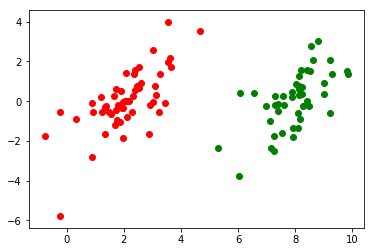

In [4]:
data_file_path = './testSet.txt'
data, labels = load_dataset(data_file_path)
draw_raw_data(data, labels)

## SMO算法（简单版本）

1. 先选择一个$\alpha$，之后再在剩余的$\alpha$中选择另一个组成对
2. 计算Ei和Ej
3. 根据公式更新对应的alpha
4. 随后更新b

在对$\alpha$更新的时候，注意
1. 当$\alpha \in (0, C]$时，样本为正确分类或者支持向量，此时Ei应该很小或者大于0的，所以违反这个的话，要被更新
2. 当$\alpha \in [0, C)$时，样本为错误分类或者支持向量，此时Ei应该很小或者小于0的，所以违反这个的话，要被更新

In [ ]:
'''
gxi, this is the hypre planar
parameter:
    data_mat: dataset matrix
    labels: labels array
    alpha: the array of alpha
    b: the model's b
    i: index of the alpha
'''
def gxi(data_mat, labels, alpha, b, i):
    Kij = np.dot(data_mat, data_mat[i, :].T).squeeze()
    return np.sum(alpha * labels * Kij) + b

'''
gxi, this is the hypre planar
parameter:
    data_mat: dataset matrix
    labels: labels array
    alpha: the array of alpha
    b: the model's b
    i: index of the alpha
'''
def SMO_simple(dataset, labels, C, toler, max_iter):
    n, m = dataset.shape
    alpha = np.zeros(n, np.float)
    b = 0
    # loop for enough times
    for it in max_iter:
        alpha_change = 0
        # outer loop select every alpha
        for i in range(n):
            gx_i = gxi(dataset, labels, alpha, b, i)
            Ei = gx_i - labels[i]
            if all([labels[i]*Ei < -toler, alpha[i] < C, alpha[i] >= 0]) or \
               all([labels[i]*Ei > toler,  alpha[i] > 0, alpha[i] <= C]):
                j = select_second_alpha(i, n)
                gx_j = gxi(dataset, labels, alpha, b, i)
                Ej = gx_j - labels[j]
                
                old_alpha_i = alpha[i]
                old_alpha_j = alpha[j]
                
                if labels[i] != labels[j]:
                    L = math.max(0, alpha[j]-alpha[i])
                    H = math.min(C, C+alpha[j]-alpha[i])
                else:
                    L = math.max(0, alpha[i]+alpha[j]-C)
                    H = math.min(C, alpha[i]+alpha[j])
                
                if L==H:
                    continue
                
                eta = np.sum(dataset[i,:]**2) + np.sum(dataset[j,:]**2) - 2*np.sum(dataset[i,:]*dataset[j,:])
                alpha[j] += labels[j]*(Ei-Ej)/eta
                alpha[j] = max(L, alpha[j])
                alpha[j] = min(H, alpha[j])
                
                if abs(alpha[j] - old_alpha_j) < 0.0001:
                    print("j need not change!!!")
                    continue
                
                alpha[i] += labels[j]*labels[i]*(old_alpha_j - alpha[j])
                
                